In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import glob
import torch.utils.data as data_utils
import math 
import time
import datetime
from torchsummary import summary
from astropy.io import fits

In [4]:
now = datetime.datetime.now()

In [10]:
now.day

3

In [24]:
NNNumbers = 0

In [4]:
startTime = time.time()

TrainImages = 45000
ValidationImages = 3000
TestImages = 12000

epochs = 50 
lr = 0.001 
Threshold = 0.5
batch_size = 500 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

DataType = 'E'
COSMOS = 'Y'
if DataType == 'E':
    bands = 1
else: 
    bands = 4

cpu


In [5]:
def LoadData(Number, DataType, COSMOS):

    import re
    import numpy as np
    
    if DataType == 'E':
        f = open('EuclidDataFile.csv','r')
    else:
        f = open('KiDSDataFile.csv','r')
    reader = f.read()
    f.close()
    
    reader = re.split('\n',reader)
    Index = int(re.split(',',reader[0])[-1])
    reader = reader[1:-1]    
    if COSMOS != 'N':
        
        if DataType == 'K':
            f = open('KiDSListCOSMOSCut.csv','r')
        else:
            f = open('EuclidListCOSMOSCut.csv','r')
        readerC = f.read()
        f.close()
        
        COSMOSCut = []
        
        for a in range(0,int(len(readerC)/7)):
            COSMOSCut.append(readerC[7*a:(7*a)+6])
         
        Output = np.zeros((Number,2))
            
        for a in range(0,Number):
            Void = re.split(',',reader[int(int(COSMOSCut[a])-100000)])
            Output[a,:] = [int(Void[0]),1-int(Void[Index])]
    
    else:
    
        Output = np.zeros((Number,2))
    
        for a in range(0,Number):
            Void = re.split(',',reader[a])
            Output[a,:] = [int(Void[0]),1-int(Void[Index])]          
    return Output

In [6]:
Output = LoadData(TrainImages+ValidationImages+TestImages, DataType, COSMOS)

In [7]:
Output

array([[1.00002e+05, 0.00000e+00],
       [1.00004e+05, 0.00000e+00],
       [1.00005e+05, 0.00000e+00],
       ...,
       [1.87052e+05, 1.00000e+00],
       [1.87054e+05, 1.00000e+00],
       [1.87055e+05, 1.00000e+00]])

In [8]:
global bands 

In [11]:
def LoadImages(Output,DataType):
    if DataType == 'E':
        Source = glob.glob('/EuclidImages/*fits')
        hdu_list = fits.open(Source[0])
        Images = np.zeros((Output.shape[0],1,hdu_list[0].data.shape[0],hdu_list[0].data.shape[1]))
        bands = 1 
        for a in range(0,Output.shape[0]):
            #Open the FITS file
            hdu_list = fits.open(str(Source[a][:-11])+str(int(Output[a,0]))+'.fits')
            print(str(Source[a][:-11])+str(int(Output[a,0]))+'.fits')
            #Extract image data
            Images[a,:,:,:] = hdu_list[0].data
            Images[a,:,:,:] = Images[a,:,:,:]/np.amax(Images[a,:,:,:])
            #Images[a,:,:,:] = (Images[a,:,:,:]-np.amin(Images[a,:,:,:]))/(np.amax(Images[a,:,:,:])-np.amin(Images[a,:,:,:]))
            #Close the FITS file
            hdu_list.close()            
      
    return Images

In [12]:
Images = LoadImages(Output,DataType)

NameError: name 'LoadImages' is not defined

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Images = torch.from_numpy(Images).float().to(device)
Output = torch.from_numpy(Output).type(torch.LongTensor).to(device)
Output.type(torch.LongTensor) 
intiallabels = Output[:,1]
labels = intiallabels

In [17]:
train = data_utils.TensorDataset(Images[:TrainImages,:], intiallabels[:TrainImages])
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)

validate = data_utils.TensorDataset(Images[TrainImages:TrainImages+ValidationImages,:], intiallabels[TrainImages:TrainImages+ValidationImages])
validate_loader = data_utils.DataLoader(validate, batch_size=batch_size, shuffle=False, drop_last=True)

test = data_utils.TensorDataset(Images[TrainImages+ValidationImages:TrainImages+ValidationImages+TestImages,:], intiallabels[TrainImages+ValidationImages:TrainImages+ValidationImages+TestImages])
test_loader = data_utils.DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

In [18]:
classes = ['No Lens', 'Lens']

In [25]:
startNNTime = time.time()  
class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(bands,30,kernel_size=15,padding=0)
        self.conv2 = nn.Conv2d(30, 15, kernel_size=15, padding=0)
        self.conv3 = nn.Conv2d(15, 5, kernel_size=5, padding=0)
        self.conv4 = nn.Conv2d(5, 1, kernel_size=5, padding=0)
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(36,512)  
        self.fc4 = nn.Linear(512, 1)

        #if DataType == 'E':
        #    torch.nn.init.kaiming_uniform_(self.conv1.weight)
        #    torch.nn.init.kaiming_uniform_(self.conv2.weight)
        #    torch.nn.init.kaiming_uniform_(self.conv3.weight)
        #    torch.nn.init.kaiming_uniform_(self.conv4.weight)
        #    torch.nn.init.kaiming_uniform_(self.fc1.weight)
        #    torch.nn.init.kaiming_uniform_(self.fc4.weight)
 
    def forward(self, x):
        x = (F.relu((self.conv1(x))))
        x = self.pool(x)
        x = (F.relu((self.conv2(x))))
        x = self.pool(x)
        x = (F.relu((self.conv3(x))))
        x = (F.relu(self.conv4(x)))
        x = x.flatten(start_dim=1)
        x = torch.squeeze(x)
        x = (F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc4(x))
        
        return x

In [26]:
model = Net().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

In [27]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    

CUDA is not available.  Training on CPU ...


In [28]:
Images.size()

torch.Size([60000, 1, 101, 101])

In [ ]:
now = datetime.datetime.now()
day = str(now.day)
mon = now.month
if mon == 1:
    month = 'Jan'
if mon == 2:
    month = 'Feb'
if mon == 3:
    month = 'Mar'
if mon == 4:
    month = 'Apr'
if mon == 5:
    month = 'May'
if mon == 6:
    month = 'Jun'
if mon == 7:
    month = 'Jul'
if mon == 8:
    month = 'Aug'
if mon == 9:
    month = 'Sep'
if mon == 10:
    month = 'Oct'
if mon == 11:
    month = 'Nov'
if mon == 12:
    month = 'Dec'

In [ ]:
# number of epochs to train the model
n_epochs = epochs

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

timecount = []
epochall = []
valloss = []
valacc = []
trainloss = []
trainacc = []


for epoch in range(n_epochs):
    # monitor training loss
    epochStartTime = time.time()#####
    correct = 0.0
    cum_loss = 0.0
    counter = 0.0

    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        data = data.device()
        target = target.type(torch.FloatTensor) 
        target = target.device()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        # Accuracy
        max_scores, max_labels = output.data.max(1)
        target = target.type(torch.LongTensor)
        correct += (max_labels == target.data).sum()
        counter += data.size(0)
        train_acc = 100 * float(correct) / counter######
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    correct = 0.0
    cum_loss = 0.0
    counter = 0.0
    for data, target in validate_loader:
        data = data.device()
        target = target.type(torch.FloatTensor)  
        target = target.device()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
                # Accuracy
        max_scores, max_labels = output.data.max(1)
        target = target.type(torch.LongTensor)
        correct += (max_labels == target.data).sum()
        counter += data.size(0)
        val_acc = 100 * float(correct) / counter######
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validate_loader.dataset)
    
    epochFinishTime = time.time()
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    print('Epoch: {} \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(
        epoch+1, 
        train_acc,
        val_acc
        ))
    print('Time: '+ str(epochFinishTime - epochStartTime))
    
    timecount.append(epochFinishTime - epochStartTime)
    epochall.append(epoch+1)
    trainloss.append(train_loss)
    trainacc.append(train_acc)
    valloss.append(valid_loss)
    valacc.append(val_acc) 
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'Pytorch1_model_'+str(day)+'_'+str(month)+'_Euclid_COSMOS_'+str(NNNumbers)+'.pt')
        torch.save(optimizer.state_dict(), 'PyTorch1_Optim_'+str(day)+'_'+str(month)+'_Euclid_COSMOS_'+str(NNNumbers)+'.pt')
        valid_loss_min = valid_loss
        NNNumbers = NNNumbers +1
        
    # The accuracy may be incorrect.

Epoch: 1 	Training Loss: 0.365688 	Validation Loss: 0.326146
Epoch: 1 	Training Acc: 87.200000 	Validation Acc: 86.500000
Time: 2273.4030408859253
Validation loss decreased (inf --> 0.326146).  Saving model ...
Epoch: 2 	Training Loss: 0.301903 	Validation Loss: 0.277274
Epoch: 2 	Training Acc: 87.200000 	Validation Acc: 86.500000
Time: 6870.2794852256775
Validation loss decreased (0.326146 --> 0.277274).  Saving model ...


In [44]:
import pandas as pd



df = pd.DataFrame({"Time":timecount, "Epoch": epochall, "Valloss": valloss, "Valacc": valacc, "trainloss":trainloss, "trainacc":trainacc})
df.to_csv('Euclid_Cosmos_'+str(day)+'_'+str(month)+'.csv', index=False)

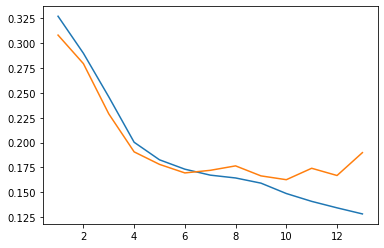

In [45]:
plt.plot(epochall,trainloss)
plt.plot(epochall,valloss)

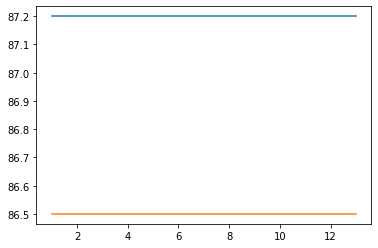

In [46]:
plt.plot(epochall,trainacc)
plt.plot(epochall,valacc)

In [33]:
model.load_state_dict(torch.load('checkpoints/Pytorch1_model_Feb13_Euclid_COSMOS_Paper15.pt'))
optimizer.load_state_dict(torch.load('checkpoints/Pytorch1_Optim_Feb13_Euclid_COSMOS_Paper15.pt'))

In [49]:
 # track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
correctInt = 0
truePositive = 0
trueNegative = 0
falsePositive = 0
falseNegative = 0
tpr = []
fpr = []
tnr = []
fnr = []
totalTarget = []
totalOutput = []
lass =[]
model.eval()
# iterate over test data
for data, target in test_loader:
    predictions = np.zeros(batch_size)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    target = target.type(torch.float)
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    for i in range(len(output)):
        if output[i] >= 0.5:
            predictions[i] = 1
        else:
             predictions[i] = 0   
    # calculate test accuracy for each object class
    totalTarget = np.append(totalTarget, target)
    totalOutput = np.append(totalOutput, output.detach().numpy())
    for i in range(batch_size):
        if target[i] == predictions[i]:
            correctInt += 1.
            if target[i] == 1:
                truePositive += 1.
                tpr = np.append(tpr, truePositive)
                fpr = np.append(fpr, falsePositive)
                tnr = np.append(tnr, trueNegative)
                fnr = np.append(fnr, falseNegative)
                lass = np.append(lass,'True Positive')
            else:
                trueNegative += 1.
                tpr = np.append(tpr, truePositive)
                fpr = np.append(fpr, falsePositive)
                tnr = np.append(tnr, trueNegative)
                fnr = np.append(fnr, falseNegative)
                lass = np.append(lass,'True Negative')
        if (target[i]==0) and (predictions[i]==1):
            falsePositive += 1.
            tpr = np.append(tpr, truePositive)
            fpr = np.append(fpr, falsePositive)
            tnr = np.append(tnr, trueNegative)
            fnr = np.append(fnr, falseNegative)
            lass = np.append(lass,'False Positive')
        if (target[i]==1) and (predictions[i]==0):#else:
            falseNegative += 1.
            tpr = np.append(tpr, truePositive)
            fpr = np.append(fpr, falsePositive)
            tnr = np.append(tnr, trueNegative)
            fnr = np.append(fnr, falseNegative)
            lass = np.append(lass,'False Negative')

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
test_acc = (correctInt/len(test_loader.dataset))*100.0
print('Test Acc: {:.6f}\n'.format(test_acc))


Test Loss: 0.168695

Test Acc: 94.500000



In [53]:
print(trueNegative)
print(falseNegative)
print(truePositive)
print(falsePositive)

10267.0
526.0
1073.0
134.0


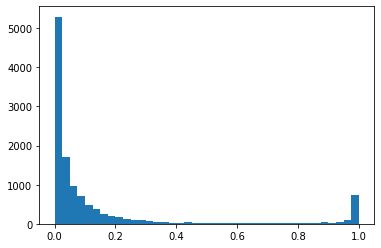

In [54]:
plt.hist(totalOutput,bins=40)
plt.show()

In [55]:
from sklearn import metrics
a, b, c = metrics.roc_curve(totalTarget,totalOutput)
roc_auc = metrics.auc(a,b)

In [56]:
roc_auc

0.9366305459997202

In [57]:
import pandas as pd

df = pd.DataFrame({"Euclid ID":Output[48000:,0],"Probability":totalOutput, "Classification": lass,"Target":totalTarget})
df.to_csv('Euclid_COSMOS_'+str(day)+'_'+str(month)+'_ROC.csv', index=False)

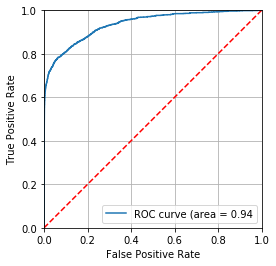

In [60]:
#plt.plot(a,b, label='ROC curve (area = '+str(roc_auc)+')')
plt.plot(a,b,label='ROC curve (area = {:.2f}'.format(roc_auc))
plt.plot([0,1],[0,1],color='red',linestyle='--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
#plt.axis('equal')
plt.gca().set_aspect('equal',adjustable='box')
plt.grid()
#plt.title('Paper_Euclid_NO_Cosmos_ROCcurve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('Euclid_COSMOS_'+str(day)+'_'+str(month)+'_ROCCURVE.pdf', bbox_inches='tight',dpi=300)
plt.show()